# SECOP 2 - XGBosst classifier


In [0]:
#!pip install plotly --upgrade

In [0]:
import pandas as pd
import numpy as np
import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
from warnings import filterwarnings
pd.options.display.max_columns = 500

In [3]:
!pip install plotly_express

In [0]:
import seaborn as sns
import plotly_express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
import psycopg2
engine = psycopg2.connect(
    database="final_db",
    user="juan",
    password="1234",
    host="nps-demo-instance.c2fezqs1nmx5.us-east-2.rds.amazonaws.com",
    port='5432'
)

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [0]:
cursor=engine.cursor()

In [0]:
import pandas as pd

sql = """
SELECT *
FROM fix_secopi
limit 1000000
"""
df=pd.read_sql(sql, con=engine)

In [152]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 27 columns):
identificacion_del_contratista    1000000 non-null object
nombre_de_la_entidad              1000000 non-null object
nit_de_la_entidad                 1000000 non-null object
nivel_entidad                     1000000 non-null object
orden_entidad                     1000000 non-null object
municipio_obtencion               1000000 non-null object
municipio_entrega                 1000000 non-null object
numero_del_contrato               999996 non-null object
numero_de_proceso                 1000000 non-null object
nom_raz_social_contratista        1000000 non-null object
moneda                            1000000 non-null object
cuantia_contrato                  1000000 non-null float64
valor_contrato_con_adiciones      1000000 non-null float64
valor_total_de_adiciones          1000000 non-null float64
sancion                           1000000 non-null object
anno_firma_del_c

## Objetivo

El objetivo del notebook es desarrollar modelos con la información actualmente disponible en la bases de datos fix_secopi. 
Esta base de datos contiene las siguientes modificaciones respecto a la base de datos del secop:

    1- Se incluyo la columna "SANCIÓN", la cual incluye un identificación para los contratos que han sido reportados como contratos con eventos de corrupción.
    
    2- Se incluyo la columna "Terminado" indica que un contrato ha sido entregado o finalizado de forma adecuada. Los contratos que presentan sanción no puede ser calificado como terminado
    
    
- El trabajo a desarrollar considera la selección de columnas de interés 
- Desarrollo de cluster con los datos con el objetivo de buscar alguna estructura en la data
- desarrollo de modelo de logistic regression a fin de plantear un posible modelo de predicción o score de corrupción [y = sanción y X= variables de interés]
- Desarrollo de RF a fn de encontrar un modelo de clasificación sobre la variable sanción

### EDA básico

In [0]:
df_sample=df.copy()

In [154]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
cuantia_contrato,1000000.0,8.284665e+07,3.982944e+09,0.000000,3.033450e+06,7.952000e+06,1.881728e+07,2.278955e+12
valor_contrato_con_adiciones,1000000.0,8.749401e+07,4.068197e+09,0.000000,3.180000e+06,8.100000e+06,1.942922e+07,2.299955e+12
valor_total_de_adiciones,1000000.0,4.647361e+06,4.144528e+08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.247763e+11
latitud,994040.0,7.177678e+00,8.336740e+00,-4.215280,4.142000e+00,5.535280e+00,7.125390e+00,4.813330e+01
longitud,994040.0,-7.480678e+01,1.532786e+00,-77.281113,-7.556359e+01,-7.528189e+01,-7.400481e+01,-6.748588e+01


### EDA Histogramas por columnas de interés como contratos de mayor cuantía o datos de mayor cantidad de contratos terminados

In [155]:
df.columns.unique()

Index(['identificacion_del_contratista', 'nombre_de_la_entidad',
       'nit_de_la_entidad', 'nivel_entidad', 'orden_entidad',
       'municipio_obtencion', 'municipio_entrega', 'numero_del_contrato',
       'numero_de_proceso', 'nom_raz_social_contratista', 'moneda',
       'cuantia_contrato', 'valor_contrato_con_adiciones',
       'valor_total_de_adiciones', 'sancion', 'anno_firma_del_contrato',
       'estado_del_proceso', 'fecha_de_firma_del_contrato',
       'fecha_ini_ejec_contrato', 'fecha_fin_ejec_contrato',
       'municipios_ejecucion', 'departamento_ejecucion', 'latitud', 'longitud',
       'terminado', 'departamento_entidad', 'state_abbr'],
      dtype='object')

Generación de columnas logaritmicas de cuantia de contrato y sanción

In [0]:
df["Log_cuantia_contrato"] =[np.log(x) if x !=0 else 0 for x in df["cuantia_contrato"]] 
df["Log_valor_contrato_con_adiciones"] =[np.log(x) if x !=0 else 0 for x in df["valor_contrato_con_adiciones"]] 
df["Log_valor_total_de_adiciones"] =[np.log(x) if x !=0 else 0 for x in df["valor_total_de_adiciones"]] 
df["terminado"]=[int(x) for x in df["terminado"]]
df["sancion"]=[int(x) for x in df["sancion"]]

In [0]:
colInteres=['identificacion_del_contratista', 'nombre_de_la_entidad','nit_de_la_entidad', 'nivel_entidad', 'orden_entidad',
'municipio_obtencion', 'municipio_entrega','nom_raz_social_contratista', 'moneda','cuantia_contrato',
'valor_contrato_con_adiciones','valor_total_de_adiciones',"Log_cuantia_contrato","Log_valor_contrato_con_adiciones",
"Log_valor_total_de_adiciones",'sancion', 'anno_firma_del_contrato','estado_del_proceso', 'fecha_de_firma_del_contrato',
'fecha_ini_ejec_contrato', 'fecha_fin_ejec_contrato','municipios_ejecucion', 'departamento_ejecucion', 'latitud',
'longitud','terminado']

Entidades con mayor cantidad de contratos, mayor cuantia del contrato, mayor cantidad de adiciones, mayor cantidad de sanciones, mayor cantidad de contratos terminados

In [158]:
df.head(1)

,identificacion_del_contratista,nombre_de_la_entidad,nit_de_la_entidad,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,numero_del_contrato,numero_de_proceso,nom_raz_social_contratista,moneda,cuantia_contrato,valor_contrato_con_adiciones,valor_total_de_adiciones,sancion,anno_firma_del_contrato,estado_del_proceso,fecha_de_firma_del_contrato,fecha_ini_ejec_contrato,fecha_fin_ejec_contrato,municipios_ejecucion,departamento_ejecucion,latitud,longitud,terminado,departamento_entidad,state_abbr,Log_cuantia_contrato,Log_valor_contrato_con_adiciones,Log_valor_total_de_adiciones
0,1032452378,CUNDINAMARCA - INSTITUTO MUNICIPAL DE RECREACI...,832000795-5,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5,Cota,Cota,072,CPS-072-2018,WILMER EDUARDO CARRERO VARGAS,Pesos (COP),8670000.0,8670000.0,0.0,0,2018-01-01,Liquidado,2018-01-22,2018-01-24,2018-07-24,Cota,Cundinamarca,5.02208,-74.004807,1,Cundinamarca,CUN,15.975379,15.975379,0.0


In [0]:
df["fecha_fin_ejec_contrato"]=pd.to_datetime(df["fecha_fin_ejec_contrato"])
df["anno_firma_del_contrato"]=pd.to_datetime(df["anno_firma_del_contrato"])

df["Anno_fin_ejec_contrato"]=[x.year for x in df["fecha_fin_ejec_contrato"]]
df["mes_fin_ejec_contrato"]=[x.month for x in df["fecha_fin_ejec_contrato"]]
df["quarter_fin_ejec_contrato"]=[x.quarter for x in df["fecha_fin_ejec_contrato"]]

df["Numeroanno_firma_del_contrato"]=[x.year for x in df["anno_firma_del_contrato"]]

In [0]:
df["quarter_fin_contrato_departamento_ejecucion"]=[x+"-"+str(y) for x,y in zip(df["departamento_ejecucion"],df["quarter_fin_ejec_contrato"])]

In [0]:
ColCluster1= ["nivel_entidad",'orden_entidad',"municipio_obtencion","municipio_entrega","moneda",'departamento_ejecucion','Log_cuantia_contrato','Log_valor_total_de_adiciones','sancion',
 'Numeroanno_firma_del_contrato',"mes_fin_ejec_contrato","quarter_fin_ejec_contrato","quarter_fin_contrato_departamento_ejecucion","municipios_ejecucion","Anno_fin_ejec_contrato",'latitud', 'longitud','terminado']

In [173]:
df[ColCluster1].head()

,nivel_entidad,orden_entidad,municipio_obtencion,municipio_entrega,moneda,departamento_ejecucion,Log_cuantia_contrato,Log_valor_total_de_adiciones,sancion,Numeroanno_firma_del_contrato,mes_fin_ejec_contrato,quarter_fin_ejec_contrato,quarter_fin_contrato_departamento_ejecucion,municipios_ejecucion,Anno_fin_ejec_contrato,latitud,longitud,terminado
0,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5,Cota,Cota,Pesos (COP),Cundinamarca,15.975379,0.00000,0,2018,7.0,3.0,Cundinamarca-3.0,Cota,2018.0,5.02208,-74.004807,1
1,TERRITORIAL,DISTRITO CAPITAL,Bogotá D.C.,Bogotá D.C.,Pesos (COP),Bogotá D.C.,17.208340,0.00000,0,2018,1.0,1.0,Bogotá D.C.-1.0,Bogotá D.C.,2018.0,4.60971,-74.081749,1
2,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1,No definido,No definido,Pesos (COP),Valle del Cauca,18.228309,0.00000,0,2018,4.0,2.0,Valle del Cauca-2.0,Cali,2019.0,3.43722,-76.522499,1
3,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,El Rosal,El Rosal,Pesos (COP),Cundinamarca,16.503358,0.00000,0,2018,12.0,4.0,Cundinamarca-4.0,El Rosal,2018.0,5.02208,-74.004807,1
4,TERRITORIAL,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,No definido,No definido,Pesos (COP),Meta,16.300417,15.60727,0,2018,10.0,4.0,Meta-4.0,Barranca de Upía,2018.0,4.14200,-73.626640,1


In [174]:
# Desbalance de datos
print("desbalance de datos:")
df["sancion"].value_counts()

print("No sancionados:{}%".format(df["sancion"].value_counts()[0]/len(df["sancion"])*100))
print("Sancionados:{}%".format(df["sancion"].value_counts()[1]/len(df["sancion"])*100))

desbalance de datos:
No sancionados:99.7927%
Sancionados:0.2073%


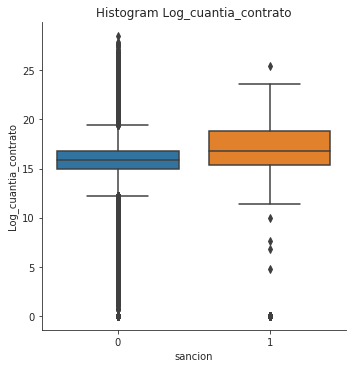

<Figure size 432x288 with 0 Axes>

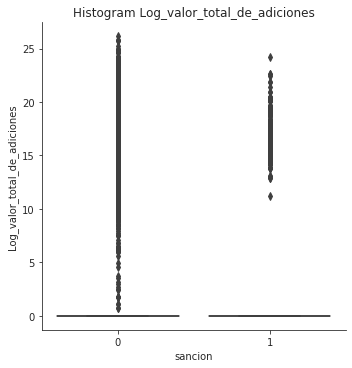

<Figure size 432x288 with 0 Axes>

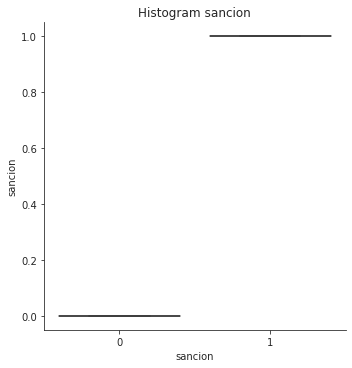

<Figure size 432x288 with 0 Axes>

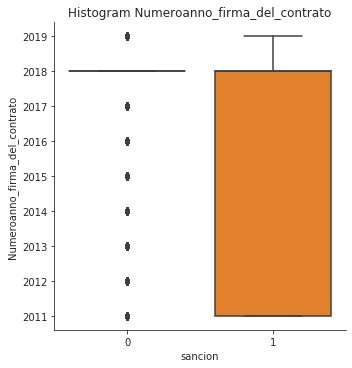

<Figure size 432x288 with 0 Axes>

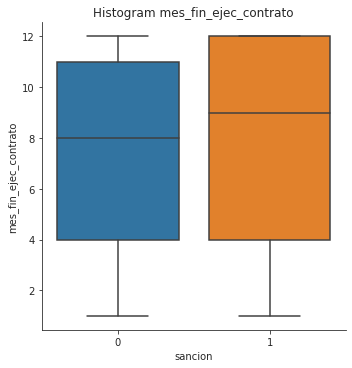

<Figure size 432x288 with 0 Axes>

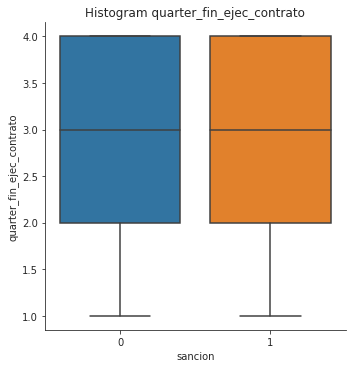

<Figure size 432x288 with 0 Axes>

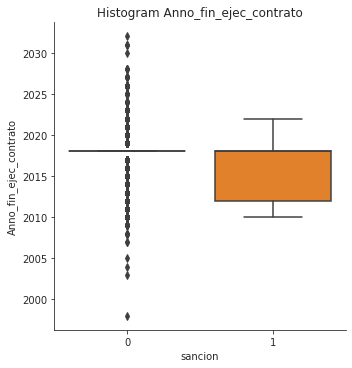

<Figure size 432x288 with 0 Axes>

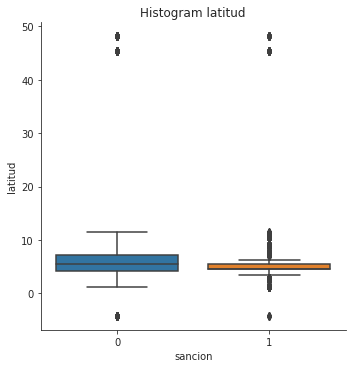

<Figure size 432x288 with 0 Axes>

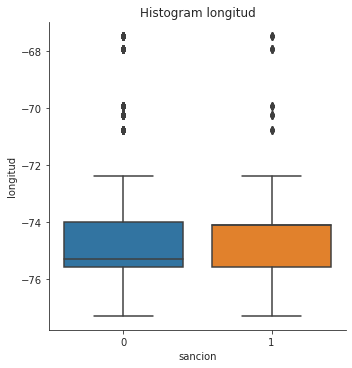

<Figure size 432x288 with 0 Axes>

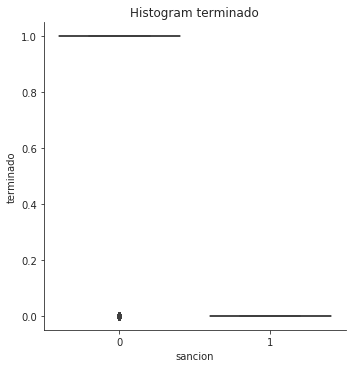

<Figure size 432x288 with 0 Axes>

In [175]:
import matplotlib.pyplot as plt

for i in df[ColCluster1].select_dtypes(exclude=['object']).columns.unique():
    sns.factorplot (x="sancion", y=i, kind="box", data=df[ColCluster1]);
    plt.title('Histogram {}'.format(i))
    plt.figure()

#### Kmeans





In [0]:
def deal_with_nans(x, thresh=0.7):
    """
    Deal with nan data
    First drop columns for which there isn't enoug data.
    Then fill missing values using median for continuous features and mode for categorical
    Finally drop columns with no variability
    :param x: (pandas.DataFrame) features dataframe
    :param thresh: (float) features with missing values below the thresh are discarted
    :return: (pandas.DataFrame) cleaned dataframe
    """

    # Drop rows with no data
    dff = x.dropna(how='all')

    # Drops columns with not enough data
    dff.dropna(thresh=thresh * len(dff), axis=1, inplace=True)

    # Identify continuous features
    float_vars = [y for y in dff.columns if 'float' in str(dff[y].dtype)]

    # Fill missing values
    for feat in dff.columns:
        if feat in float_vars:
            # Fill continuous features with median
            dff[feat] = dff[feat].fillna(dff[feat].median())
        else:
            # Fill categorical features with mode
            dff[feat] = dff[feat].fillna(dff[feat].mode()[0])

    # Drops columns with no variability
    dff = dff[[y for y in dff.columns if len(dff[y].unique()) > 1]]

    # Returns dataframe with no NaNs
    return dff


def clean_outliers(x, alpha=0.05):
    """
    Put all outliers on the confidence interval limit.
    :param x: (pandas.DataFrame) matrix of features
    :param alpha: (float) significance, 5% by default
    :return: (pandas.DataFrame) matrix with no outliers
    """

    # Cleaning Initialization
    x_c = x.copy()

    # Identification of categorical variables
    cont_vars = [x for x in x_c.columns if 'float' in str(x_c[x].dtype)]

    # If no continuous variables
    if len(cont_vars) == 0:
        return x_c

    # Cleaning
    for var in cont_vars:
        ll = x_c[var].quantile(alpha)
        ul = x_c[var].quantile(1-alpha)
        x_c[var] = [ll if x < ll else (ul if x > ul else x) for x in x_c[var]]

    # Return
    return x_c


def standarize(x):
    """
    Normalize data
    :param x: (pandas.DataFrame) matrix to normalize
    :return: (pandas.DataFrame) normalized matrix
    """

    # Outliers Treatment
    x_oc = clean_outliers(x)

    scale = StandardScaler()
    return pd.DataFrame(scale.fit_transform(x_oc), columns=x.columns, index=x_oc.index)


def get_principal_componets(x, n_pca=None):
    """
    Obtain the principal components from a set of continuous features.
    If the number of components is not especified, the model find the minimum number
    required to explain 90% of variance.
    :param x: (pandas.DataFrame) matrix from which the components are extracted
    :param n_pca: number of components
    :return: (pandas.DataFrame) matrix of components
    """

    # Standarization
    x_std = standarize(x)

    # Identify minimum number of components to explain 90% of the variability
    if n_pca is None:
        pca = PCA(random_state=1234)
        pca.fit(x_std)
        loadings = [round(y, 2) for y in pca.explained_variance_ratio_]
        cumsumload = list(np.cumsum(loadings))
        ncomps = [(y + 1, cumsumload[y]) for y in range(len(cumsumload))]
        n_pca = [y for y in ncomps if y[1] >= 0.8][0][0]

    # Calculate and return pcs
    pca = PCA(n_components=n_pca, random_state=1234)
    dp = pd.DataFrame(
        pca.fit_transform(x_std),
        columns=['PCA '+str(i+1) for i in range(n_pca)],
        index=x.index
    )
    return dp


Selección de columnas de interés y prerpocesamiento para standarizar las variables númericas y hacer One-hot-encoding a las variables categoricas

In [0]:
dfCluster=df[ColCluster1].replace([np.inf, -np.inf], np.nan)

In [0]:
#Separación del tipo de datos
df_Numeric = dfCluster.select_dtypes(include=['float64','int64'])
df_Cat = dfCluster.select_dtypes(include=['object'])

In [0]:

df_Numeric=df_Numeric.replace([np.inf, -np.inf], np.nan)
df_Numeric=deal_with_nans(df_Numeric) 

In [0]:
# Estandarización de datos
scaler = StandardScaler()
# fit df
scaler.fit(df_Numeric)
StandardScaler(copy=True, with_mean=True, with_std=True)

df_StandScale = scaler.transform(df_Numeric)
# Df transform
df_StandScale= pd.DataFrame(df_StandScale, columns=df_Numeric.columns)

In [181]:
df_Cat_OHE= pd.get_dummies(df_Cat)
df_Cat_OHE.shape

(1000000, 3331)

In [0]:
# PCA con el objetivo de reducir dimensionalmente la cantidad de columnas 

In [0]:
def Pca_Explication(X):
    """
    Get the explain variance by each PC element.
    Params: X dataframe to transform
    Return: 
    """
    pca= PCA(n_components = None)
    df_PCA = pca.fit_transform(X)
    Exp_var = pca.explained_variance_ratio_
    Exp_var=pd.DataFrame(Exp_var, columns=['VarExpPor'])
    Exp_var["cum"]=Exp_var.VarExpPor.cumsum()
    return Exp_var

In [0]:
Pca_Explication(df_Cat_OHE).T

In [0]:
df_Cat_OHEPCA=get_principal_componets(df_Cat_OHE,80)

Obtención de pca de df numerico y df categorico

In [0]:
df_SOHE = pd.merge(df_Numeric, df_Cat_OHEPCA, left_index=True, right_index=True, suffixes=('_Num', '_Cat'))

In [116]:
df_SOHE.head()

,Log_cuantia_contrato,Log_valor_total_de_adiciones,sancion,Numeroanno_firma_del_contrato,Anno_fin_ejec_contrato,latitud,longitud,terminado,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,PCA 11,PCA 12,PCA 13,PCA 14,PCA 15,PCA 16,PCA 17,PCA 18,PCA 19,PCA 20,PCA 21,PCA 22,PCA 23,PCA 24,PCA 25,PCA 26,PCA 27,PCA 28,PCA 29,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 35,PCA 36,PCA 37,PCA 38,PCA 39,PCA 40,PCA 41,PCA 42,PCA 43,PCA 44,PCA 45,PCA 46,PCA 47,PCA 48,PCA 49,PCA 50,PCA 51,PCA 52,PCA 53,PCA 54,PCA 55,PCA 56,PCA 57,PCA 58,PCA 59,PCA 60,PCA 61,PCA 62,PCA 63,PCA 64,PCA 65,PCA 66,PCA 67,PCA 68,PCA 69,PCA 70,PCA 71,PCA 72,PCA 73,PCA 74,PCA 75,PCA 76,PCA 77,PCA 78,PCA 79,PCA 80
0,13.910821,0.000000,0,2017,2017,5.022080,-74.004807,1,-2.638159,4.724509,-2.709603,-0.926839,1.882618,-1.091414,-3.637450,1.796786,-0.469516,2.701800,0.278361,-0.958255,-2.455232,1.010482,-6.030152,-0.868524,2.753014,1.347172,-0.101395,-0.518892,-0.154503,2.382242,2.817084,3.513012,5.192636,-1.410518,-3.752132,0.535691,-4.009802,5.959496,-3.142346,-8.911663,-2.268117,2.712178,5.689378,-2.531975,5.491637,2.873980,1.085044,-5.824696,4.024776,-4.029577,-1.143333,0.420853,-6.695473,-1.687158,-1.509546,-2.868036,8.905060,5.882798,1.111670,-3.689558,0.945807,-4.424964,-8.909934,-1.568249,7.854904,2.964168,5.463047,1.531487,-3.918884,-0.448599,17.137897,-4.436008,0.715148,4.158709,2.991721,-3.955400,-6.951743,-0.325813,2.943097,3.889983,-6.219889,1.833220,2.109824,2.592695,2.230601,1.214790,1.514446,-14.286598
1,16.605330,0.000000,0,2018,2018,4.609710,-74.081749,1,5.905647,2.260310,-0.354559,-0.746406,0.198267,-0.031442,-0.361859,0.614099,-0.509950,0.201230,0.349548,0.304737,-0.002453,-0.020800,-1.066438,-0.104703,0.116161,0.608105,-0.030926,0.453853,0.277975,-0.077311,0.527903,-0.226552,-0.207289,-0.340617,0.511646,1.043743,-0.336769,0.281901,0.032913,-0.267739,-1.112644,-0.149122,-0.372050,-0.333628,-0.118701,0.347928,0.027496,0.057676,-0.111605,-0.056649,-0.148621,0.084236,0.107423,-0.046684,0.141006,0.039225,0.036205,0.108405,0.103220,-0.042937,-0.021628,0.004722,0.073448,-0.135381,0.060879,0.038267,0.139670,0.043258,-0.142813,0.096799,-0.116796,0.026060,-0.013945,-0.106386,0.020539,-0.000305,0.016612,0.037953,-0.060567,-0.073734,0.094790,0.071103,0.060405,0.007547,-0.022152,-0.035321,0.046114,-0.055269
2,16.636889,15.874749,0,2018,2019,48.133302,-75.696114,1,-1.093916,-2.249327,0.196582,0.253731,-1.233597,2.414061,-2.285730,-5.743510,-0.071558,3.556840,-0.204836,-2.422417,0.145245,0.068708,-2.347030,1.808364,-0.142641,0.050444,0.371925,1.460262,0.326085,0.777274,-0.155513,0.381136,0.756085,-0.130827,1.244513,-0.349747,0.973756,-0.954467,1.135156,0.302206,-0.292792,0.857246,-0.155904,0.743298,0.185564,1.040450,-0.421966,1.772653,-0.731255,-0.602415,0.112778,0.712793,1.259913,1.632841,1.798104,0.682390,0.386886,2.587719,0.550156,0.036766,-1.642307,1.031081,0.290889,-0.179489,0.768964,-0.005759,1.018021,0.455196,0.187807,-2.081841,0.542557,1.449531,0.791188,-1.285365,-1.291348,-0.540632,1.663741,0.023946,-0.113230,-0.625236,-0.243764,0.093589,-0.005129,0.925986,-0.776744,0.279507,1.734274,2.867139
3,16.705882,0.000000,0,2018,2018,3.437220,-76.522499,0,-0.160253,-2.325685,-0.051310,0.157329,-0.412122,-0.391056,-0.752656,0.179451,-0.474670,-0.799363,0.688101,0.052455,-0.048843,0.441861,0.469682,-0.457813,0.072040,-0.215431,-0.446053,-0.045071,0.222289,-0.157035,0.050578,0.054195,-0.047343,0.332020,0.112111,-0.210445,-0.064226,-0.145225,-0.062560,0.072481,-0.149388,-0.049032,0.126565,0.253316,-0.037697,-0.132313,0.037695,-0.005692,0.047817,-0.055169,0.113196,-0.161562,-0.040105,-0.028727,-0.090208,-0.002975,0.064734,-0.034526,0.006662,0.080346,0.012712,-0.065020,-0.087386,0.036301,0.009729,0.049287,-0.062015,-0.014597,0.109934,0.006827,-0.060370,-0.026205,0.033599,0.182122,-0.037803,0.054490,0.005856,-0.059005,-0.027589,0.027150,-0.028577,-0.033783,-0.052245,0.077751,0.028750,-0.041256,-0.034854,-0.103390
4,15.384126,0.000000,0,2018,2018,5.535280,-73.367783

In [0]:
# Descripción distribución de datos en función de la categoría sancionado

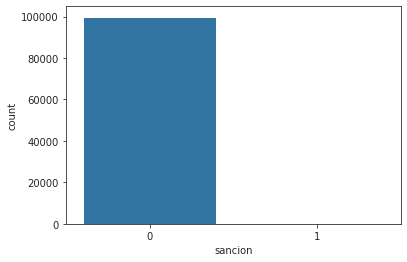

In [118]:
ax = sns.countplot(x="sancion", data=df_SOHE)

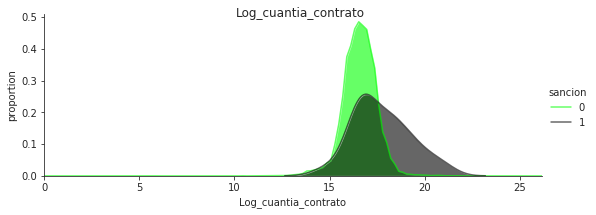

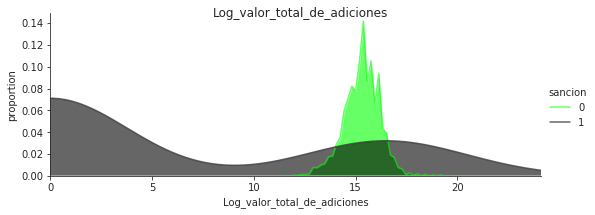

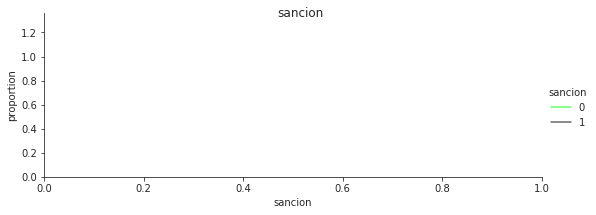

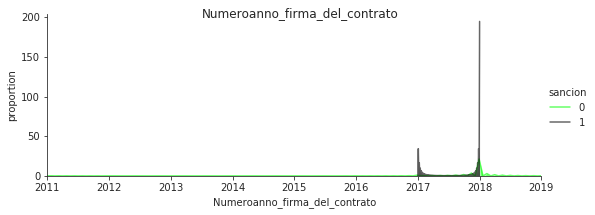

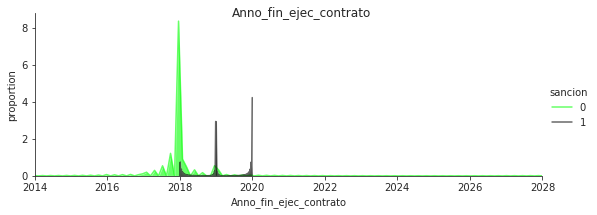

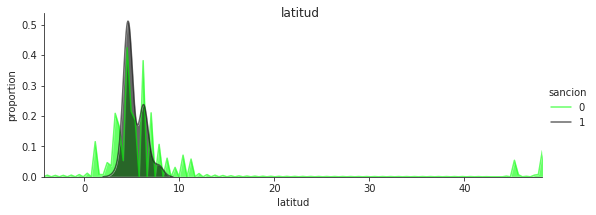

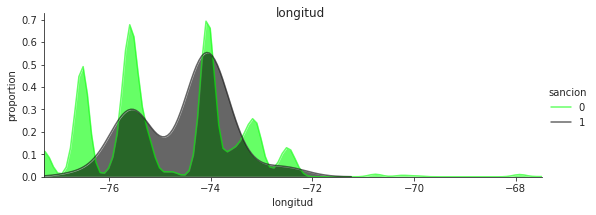

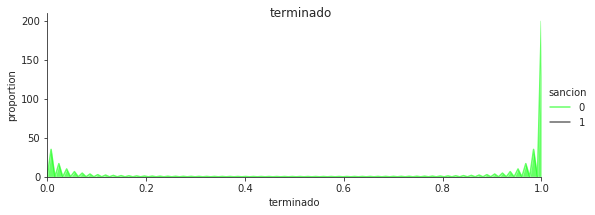

In [119]:
def plot_distribution(data_select): 
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(dfCluster, hue = 'sancion',aspect = 2.5, palette ={0 : 'lime', 1 :'black'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(dfCluster[data_select].min(), dfCluster[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

for i in df_Numeric.columns.unique():
   plot_distribution(i)   

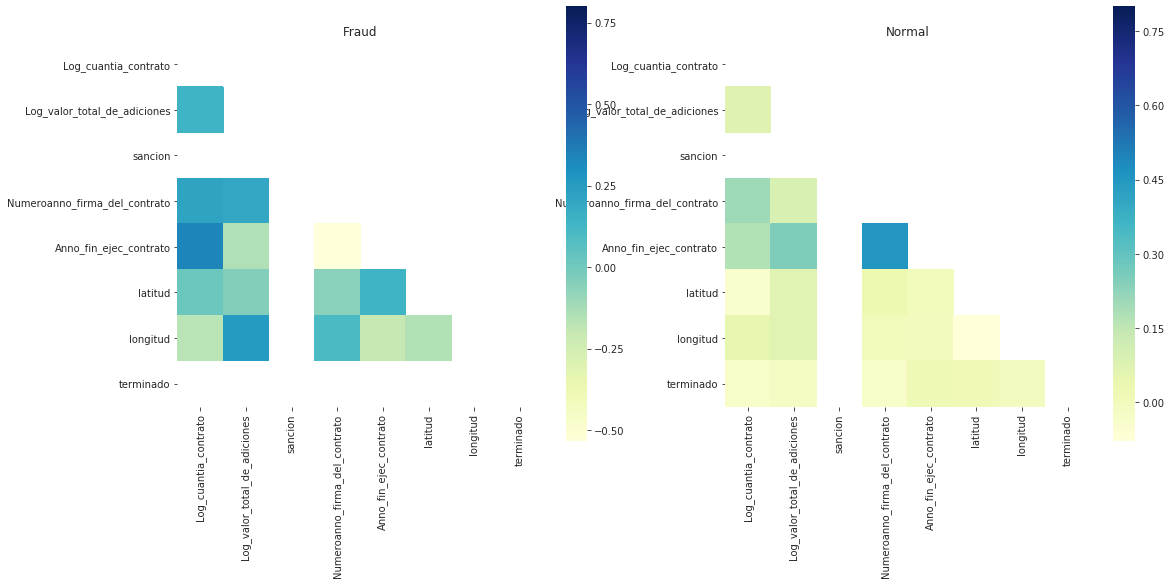

In [120]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = dfCluster.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((dfCluster.loc[dfCluster['sancion'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((dfCluster.loc[dfCluster['sancion'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

In [0]:
#### Kmeans sobre unión de df categoricos
X=df_SOHE.copy()
X=X.drop(columns=["sancion","terminado"])

In [0]:
y=df_SOHE["sancion"]

In [123]:
## Generación de modelo #1 - Modelo sin estratificación del modelo 

from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.tools import FigureFactory as FF
import warnings
warnings.filterwarnings('ignore')

In [0]:
def model_performance(model,y_test, y_pred,y_score): 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
    data=[[Accuracy , Precision, Recall, F1_score]]
    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    '''#Feature importance
    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data   = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))'''
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).as_matrix()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        #'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    return py.iplot(fig)
    #return fig.show()

In [0]:
#accuracy=cross_val_score(clf, X_train, y_train, scoring=balanced_accuracy_score, cv=3).mean()

In [126]:
from warnings import filterwarnings

#train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

   
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1234)

def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(#tree_method='gpu_hist', gpu_id=0,
                            n_estimators =int(space["n_estimators"]),
                            colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])
    
    
    
    # Fit the classsifier
    
    
    clf.fit(X_train, y_train,eval_metric=balanced_accuracy_score)
    
    
    # Calculate our Metric - accuracy
    
    
    accuracy=cross_val_score(clf, X_train, y_train, scoring=make_scorer(balanced_accuracy_score), cv=3).mean()
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

space ={'n_estimators':hp.quniform ('x_n_estimators', 100, 1000, 100),
        'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.RandomState(1234)
            )
print(best)



#XGBoost randomsearchCV
best_fit = xgb.XGBClassifier(#tree_method='gpu_hist', gpu_id=0,
                            n_estimators =int(best["x_n_estimators"]),
                            colsample_bytree=best['x_colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(best['x_max_depth']),
                            min_child_weight = best['x_min_child_weight'],
                            subsample = best['x_subsample'],
                           gamma = best['x_gamma'],
                           reg_lambda = best['x_reg_lambda'])
# fit XGB
best_fit.fit(X_train, y_train,eval_metric=balanced_accuracy_score)
    
print("y predict xg")
y_pred = best_fit.predict(X_train)
y_score = best_fit.predict_proba(X_test)[:,1]

y_pred_test = best_fit.predict(X_test)

XG_train_score = balanced_accuracy_score(y_train,y_pred)
XG_test_score = balanced_accuracy_score(y_test, y_pred_test)


print("El Score de training del modelo XG fue: {}".format(XG_train_score))
print("El Score de test del modelo  XG fue: {}".format(XG_test_score))


# Explained Variability Calculation
importances = pd.DataFrame(best_fit.feature_importances_.tolist(), columns=['explanation'])
features = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
df = pd.concat([features, importances], axis=1)
#df.explanation = df.explanation * best_fit.score(X_train, y_train) * 100
df.sort_values('explanation', ascending=False, inplace=True)
df.set_index('feature', inplace=True)    
 


100%|██████████| 5/5 [07:20<00:00, 81.16s/it, best loss: -0.5]
{'x_colsample_bytree': 0.8702223906761407, 'x_gamma': 0.19660346387492067, 'x_max_depth': 8.0, 'x_min_child_weight': 9.0, 'x_n_estimators': 100.0, 'x_reg_lambda': 0.1130526021429622, 'x_subsample': 0.9271541922003506}
y predict xg
El Score de training del modelo XG fue: 0.5588235294117647
El Score de test del modelo  XG fue: 0.5


In [127]:
df.head(10)

,explanation
feature,
PCA 71,0.047800
PCA 16,0.044044
PCA 66,0.040955
PCA 70,0.039104
PCA 14,0.032027
PCA 61,0.028710
PCA 48,0.027437
PCA 72,0.026300
PCA 33,0.025687


In [0]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                      y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

#Show metrics
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
Precision =  (tp/(tp+fp))
Recall    =  (tp/(tp+fn))
F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
data=[[Accuracy , Precision, Recall, F1_score]]

#Roc curve
model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
fpr, tpr, t = roc_curve(y_test, y_score)
trace3 = go.Scatter(x = fpr,y = tpr,
                     name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))

In [129]:
conf_matrix

array([[29984,     0],
       [   16,     0]])

In [130]:
model_roc_auc

0.933

In [131]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred_test)

0.5

In [132]:
model_performance(best_fit,y_test, y_pred_test,y_score)

In [0]:
# ANN

In [0]:
import keras

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential([
    Dense(units=20, input_dim = X_train.shape[1], activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(units=20,activation='relu'),
    Dense(units=24,activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                1740      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                504       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 25        
Total params: 3,273
Trainable params: 3,273
Non-trainable params: 0
____________________________________________________

In [139]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=30, epochs=15)



Epoch 1/15
70000/70000 [==============================] - 4s 50us/step - loss: 0.0078 - acc: 0.9995
Epoch 2/15
70000/70000 [==============================] - 3s 45us/step - loss: 0.0078 - acc: 0.9995
Epoch 3/15
70000/70000 [==============================] - 3s 44us/step - loss: 0.0078 - acc: 0.9995
Epoch 4/15
70000/70000 [==============================] - 3s 44us/step - loss: 0.0078 - acc: 0.9995
Epoch 5/15
70000/70000 [==============================] - 3s 44us/step - loss: 0.0078 - acc: 0.9995
Epoch 6/15
70000/70000 [==============================] - 3s 46us/step - loss: 0.0078 - acc: 0.9995
Epoch 7/15
70000/70000 [==============================] - 3s 43us/step - loss: 0.0078 - acc: 0.9995
Epoch 8/15
70000/70000 [==============================] - 3s 43us/step - loss: 0.0078 - acc: 0.9995
Epoch 9/15
70000/70000 [==============================] - 3s 43us/step - loss: 0.0078 - acc: 0.9995
Epoch 10/15
70000/70000 [==============================] - 3s 43us/step - loss: 0.0078 - acc: 0.9995

In [140]:
score = model.evaluate(X_test, y_test)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(score[1]*100,score[0]))

30000/30000 [==============================] - 1s 19us/step
Test Accuracy: 99.95%
Test Loss: 0.008596416856180955


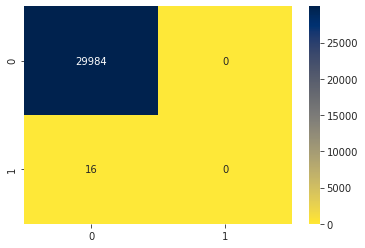

In [141]:
y_predN = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cm = confusion_matrix(y_test, y_predN.round())
sns.heatmap(cm, annot=True, fmt='.0f', cmap='cividis_r')
plt.show()

In [0]:
#SMOTE Sampling

In [143]:
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_sample(X, y)
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)
y_smote.iloc[:,0].value_counts()

1    99950
0    99950
Name: 0, dtype: int64

In [0]:
X_trainSmote, X_testSmote, y_trainSmote, y_testSmote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=0)
X_trainSmote = np.array(X_trainSmote)
X_testSmote = np.array(X_testSmote)
y_trainSmote = np.array(y_trainSmote)
y_testSmote = np.array(y_testSmote)


In [146]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_trainSmote, y_trainSmote, batch_size = 30, epochs = 15)

Epoch 1/15
139930/139930 [==============================] - 6s 45us/step - loss: 8.0455 - acc: 0.5008
Epoch 2/15
139930/139930 [==============================] - 6s 43us/step - loss: 8.0455 - acc: 0.5008
Epoch 3/15
139930/139930 [==============================] - 6s 43us/step - loss: 8.0455 - acc: 0.5008
Epoch 4/15
139930/139930 [==============================] - 6s 42us/step - loss: 8.0455 - acc: 0.5008
Epoch 5/15
139930/139930 [==============================] - 6s 43us/step - loss: 8.0455 - acc: 0.5008
Epoch 6/15
139930/139930 [==============================] - 6s 42us/step - loss: 8.0455 - acc: 0.5008
Epoch 7/15
139930/139930 [==============================] - 6s 42us/step - loss: 8.0455 - acc: 0.5008
Epoch 8/15
139930/139930 [==============================] - 6s 42us/step - loss: 8.0455 - acc: 0.5008
Epoch 9/15
139930/139930 [==============================] - 6s 44us/step - loss: 8.0455 - acc: 0.5008
Epoch 10/15
139930/139930 [==============================] - 6s 44us/step - loss: 

In [148]:
scoreSmote = model.evaluate(X_testSmote, y_testSmote)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(scoreSmote[1]*100,scoreSmote[0]))

59970/59970 [==============================] - 1s 20us/step
Test Accuracy: 49.80%
Test Loss: 8.090762559115658


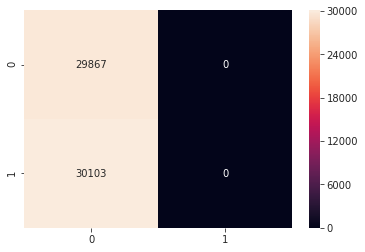

In [149]:
y_predSmote = model.predict(X_testSmote)
y_testSmote = pd.DataFrame(y_testSmote)
cmSmote = confusion_matrix(y_testSmote, y_predSmote.round())
sns.heatmap(cmSmote, annot=True, fmt='.0f')
plt.show()

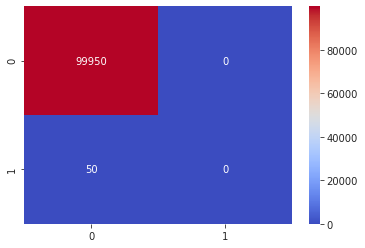

In [150]:
y_pred2 = model.predict(X)
y_test2 = pd.DataFrame(y)
cm2 = confusion_matrix(y_test2, y_pred2.round())
sns.heatmap(cm2, annot=True, fmt='.0f', cmap='coolwarm')
plt.show()

## Saving models

In [0]:
import pickle

In [0]:
# save the model to disk
filename = 'RF model 1-10k.sav'
filename2 = 'XG model 1-10k.sav'
pickle.dump(resultadoClasificadorRFXG[2], open(filename, 'wb'))
pickle.dump(resultadoClasificadorRFXG[1], open(filename2, 'wb'))